## 1. Functions that allow reconstruction

In [33]:
import numpy as np
from qutip import wigner, fock, Qobj, displace, destroy, tensor, qeye, coherent
from scipy.special import genlaguerre
from math import sqrt, factorial
import qutip
import matplotlib.pyplot as plt
from scipy.linalg import lstsq, eigh, svd  
from scipy.sparse.linalg import LinearOperator, lsqr
import h5py
from tcsim.visualization import*

def make_disps(xmax, N):
    xs = np.linspace(-xmax, xmax, N)
    X, Y = np.meshgrid(xs, xs)
    return (X + 1j*Y).flatten()
# flatten means a matrix can be transformed to a list with the order of row.

def vectorize(rho):
    """
    Turn hermitian matrix rho into a real vector
    vectorize(rho)[:d] = diag(rho)
    vectorize(rho)[d:d + d*(d-1)/2] = Re[upper_triangle(rho)]
    vectorize(rho)[d + d*(d-1)/2:]  = Im[upper_triangle(rho)]
    """
    d = rho.shape[0]  ## the shape of first column - dimension of matrix, e.g. 3x3 matrix d = 3
    n_offd = d*(d-1)//2 
    ret = np.zeros(d**2) #array of zeros with dimensionality d**2
    i = 0
    for m in range(d):
        ret[m] = rho[m, m].real #mth entry in ret is real part of (m,m) diagonal entry of matrix, capped at d
        for n in range(m+1, d):
            ret[d+i] = rho[m, n].real  #set d+ith entry in ret to real part of (m,n) off diagonal entry of matrix
            ret[d+n_offd+i] = rho[m, n].imag
            i += 1
    return ret


def matricize(rvec):
    """
    Invert the vectorize operation such that matricize(vectorize(rho)) == rho
    """
    d = int(np.sqrt(len(rvec)))
    n_offd = d*(d-1)//2
    ret = np.diag(rvec[:d]).astype(np.complex) # 将rvec[:d]转化为一个对角矩阵，并且用a+jb的形式表示
    i = 0
    for m in range(d):
        for n in range(m+1, d):
            real = rvec[d+i]
            imag = rvec[d+n_offd+i]
            val = real + 1j*imag
            ret[m, n] = val
            ret[n, m] = val.conj()
            i += 1
    return ret


def complex_char_mat(disps, d):
    n_disp = len(disps)
    n_offd = (d*(d-1))//2
    dm = np.zeros((n_disp, d*d), dtype=np.complex)
    alpha = disps
    i = 0
    B = abs(alpha)**2
    for n in range(d):
        dm[:, n] = genlaguerre(n, 0)(B)
        for m in range(n+1, d):
            off_d = np.sqrt(factorial(n)/factorial(m)) * genlaguerre(n, m-n)(B)
            dm[:, d+i] = (off_d * (alpha**(m-n) + (-alpha.conjugate())**(m-n)))
            dm[:, d + n_offd + i] = (1j * off_d * (alpha**(m-n) - (-alpha.conjugate())**(m-n)))
            i += 1
    dm = np.einsum('ij,i->ij', dm, np.exp(-B / 2))
    return dm

def reconstruct_char_complex(char, disps, dim):
    M = complex_char_mat(disps, dim)
    rv = lsqr(M, char, damp = 2)[0]
    rho = matricize(rv)
    return rho



def reconstruct_char_from_data(data, x_data, y_data, dim, scale, plot=True):
  
    # turn x_data and y_data into an appropriate grid and flatten to hand it to reconstruct_char_complex as disps
    X, Y = np.meshgrid(x_data, y_data)
    
    disps = (1j*X + Y).flatten()
    
    # correct offset and scale data
    #data_scale_offset = (data - np.mean(data[0]))/np.max(data)
    rho = Qobj(reconstruct_char_complex(data.flatten(), disps*scale, dim))
    
    if plot:
        fig, ax = plt.subplots(1,3, figsize = (10,10) )
        ax[0].set_aspect('equal')
        ax[1].set_aspect('equal')
        ax[2].set_aspect('equal')
        ax[0].pcolormesh(x_data, y_data, data, cmap = 'bwr',vmin = -1, vmax= 1) # [4:31]
        plot_char(qt.tensor(qt.fock(2,0).dag()*qt.fock(2,0),rho), ax=ax[1], max_alpha = 6)
        plot_char(qt.tensor(qt.fock(2,0).dag()*qt.fock(2,0),rho), ax=ax[2], real=False, max_alpha = 6 )
        ax[0].set_title("Experimental Data")
        ax[1].set_title("Reconstructed char real")
        ax[1].set_title("Reconstructed char im")
        
    return rho
    
    

In [256]:
######
xy_max = 1.6
xy_min = -1.6
xy_step = 0.09

x_vec = np.arange(xy_min, xy_max + xy_step / 2, xy_step)
y_vec = x_vec

file = h5py.File(filepath, 'r')
data = file['data']

import h5py

# opening the file and loading the data
filepath = (
    r"C:\Users\jonat\Desktop\Coding\tcsim\Data Analysis\Data\102851_panther_ECD_characteristic_func.h5"
)
with h5py.File(filepath, "r") as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    print("Keys: %s" % f.keys())
    # get first object name/key; may or may NOT be a group
    a_group_key = list(f.keys())[0]
    print((f["data"]).keys())
    print(list((f["data"]).keys()))
    I_group_key = list((f["data"]).keys())[0]
    Q_group_key = list((f["data"]).keys())[1]
    I = data[I_group_key] # returns as a h5py dataset object
    Q = data[Q_group_key]
    
    print(np.shape(I[()][0])) 
print(np.shape(I[:])) #(repetition, index _x and y)
print(np.shape(I[:,1])) #(repetition, index _x and y)
print(len(x_vec))

repetitions = (np.shape(I[:,1])[0]) 
data_organzed = np.zeros(repetitions)
data_mean = np.mean(I,axis =0)
#print(np.shape(data_mean))
data_organzed = np.reshape(data_mean,((len(x_vec), len(x_vec))))
#print(data_organzed)

def scale(col, min, max):
    range = col.max() - col.min()
    a = (col - col.min()) / range
    return a * (max - min) + min

data = scale(data_organzed, -1, 1)

I_avg = data

Keys: <KeysViewHDF5 ['data', 'mixer_offsets', 'mode_names', 'operations', 'ports', 'rotation_ampxs']>
<KeysViewHDF5 ['I', 'Q']>
['I', 'Q']
(1369,)
(33, 1369)
(33,)
37


## 2. Load Data

Text(0.5, 1.0, 'Characteristic_function')

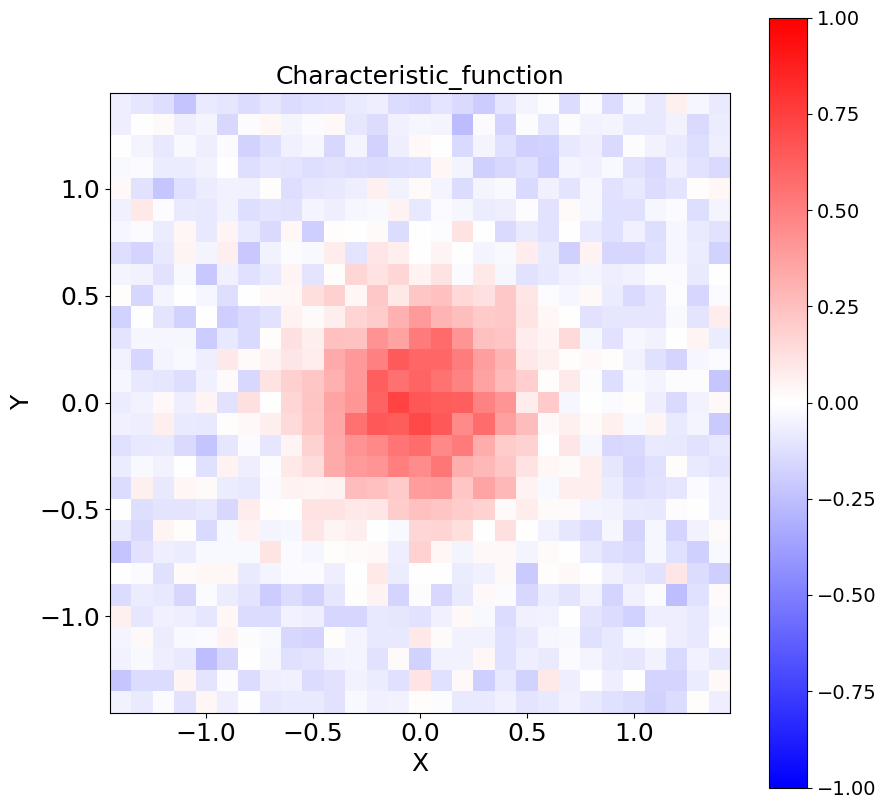

In [34]:
######

import h5py

# opening the file and loading the data
filepath = (
    r"C:\Users\jonat\Desktop\Coding\tcsim\Data Analysis\Data\111119_panther_ECD_char.h5"
)
f = h5py.File(filepath, "r")
data_iavg = f['data']['I_AVG']
data_iavg.shape
z = np.array(data_iavg) # minus sign to make epxeriment and simulation have the same polarity


def scale(col, min, max):
    range = col.max() - col.min()
    a = (col - col.min()) / range
    return a * (max - min) + min

z_offset = -(z-np.mean(z[0]))
zscale = scale(z_offset,0,1)
zscale = zscale - np.mean(zscale)

# Data Plotting
x_data = np.array(f['data']['x']) # -1.8 to including 1.8
y_data = np.array(f['data']['y'])

fig, ax = plt.subplots(figsize = (10,10) )
ax.set_aspect('equal')
plt.pcolormesh(x_data, y_data, zscale, cmap = 'bwr', vmin = -1 , vmax = 1) # [4:31]
plt.colorbar()
plt.xlabel("X", fontsize = 18)
plt.ylabel('Y', fontsize = 18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Characteristic_function', fontsize=18)

In [7]:
xvec = np.linspace(1.5,-1.5, 20)

grid_real, grid_im = char_func_grid(vac,x_data[:,1])
x_data[:,1]

array([-1.40000000e+00, -1.30000000e+00, -1.20000000e+00, -1.09999999e+00,
       -9.99999993e-01, -8.99999991e-01, -7.99999990e-01, -6.99999988e-01,
       -5.99999987e-01, -4.99999985e-01, -3.99999984e-01, -2.99999982e-01,
       -1.99999981e-01, -9.99999791e-02,  2.23517418e-08,  1.00000024e-01,
        2.00000025e-01,  3.00000027e-01,  4.00000028e-01,  5.00000030e-01,
        6.00000031e-01,  7.00000033e-01,  8.00000034e-01,  9.00000036e-01,
        1.00000004e+00,  1.10000004e+00,  1.20000004e+00,  1.30000004e+00,
        1.40000004e+00])

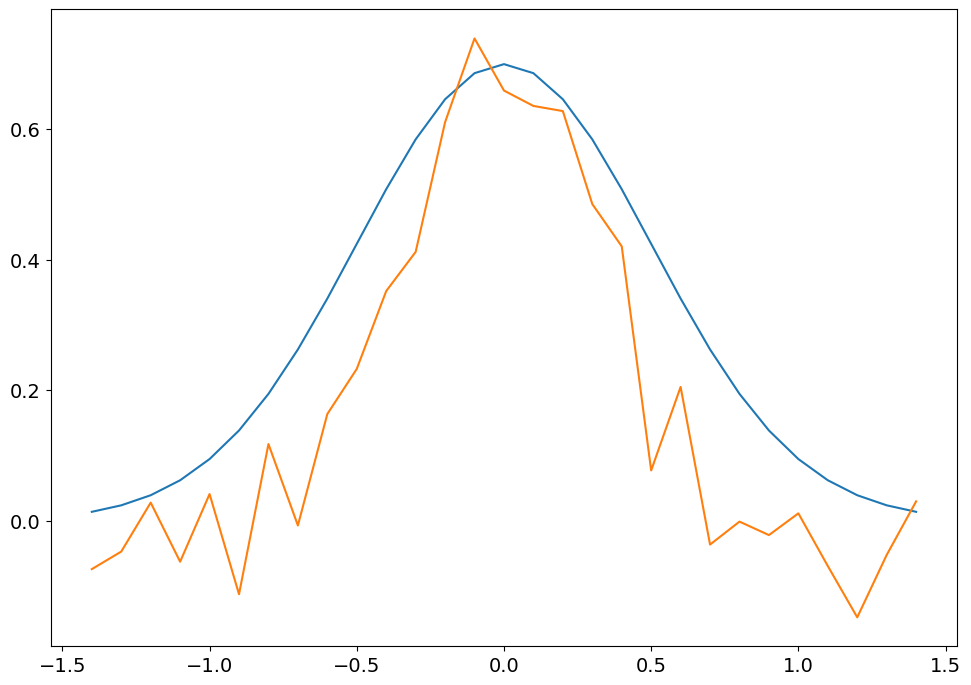

In [61]:
plt.plot(x_data[:,1],0.7*theo_data[:,14])
plt.plot(x_data[:,1],zscale[:,14])

In [50]:
x_data[:,1][14]

2.2351741790771484e-08

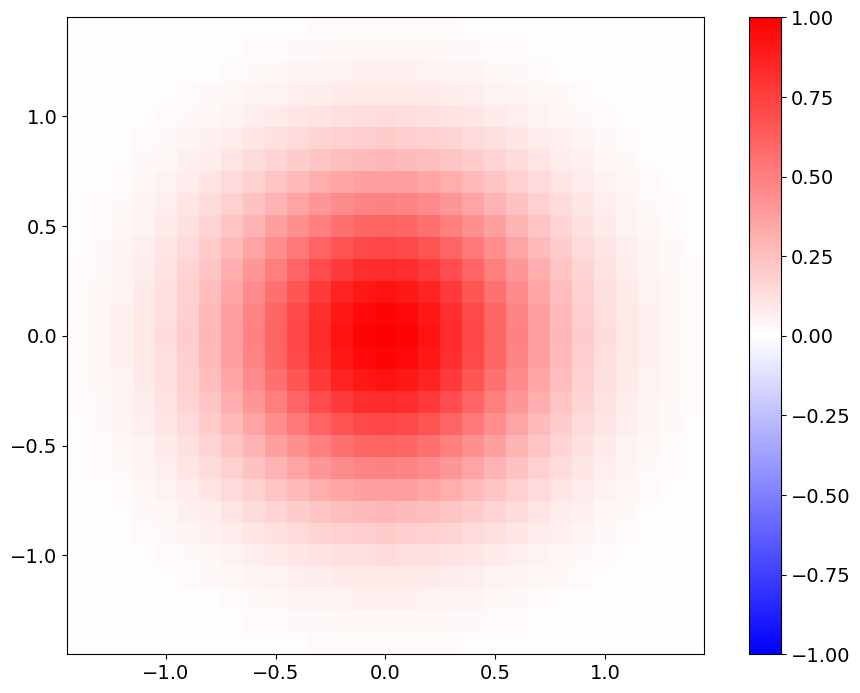

In [44]:
def gaussian2(x,y):
    sigma = 0.5
    return np.exp(-(x**2+y**2)/(2*sigma**2))

X,Y = np.meshgrid(x_data[:,1],x_data[:,1])
theo_data = gaussian2(X,Y)

fig, ax = plt.subplots()
im = ax.pcolormesh(x_data[:,1],x_data[:,1],theo_data, vmin = -1, vmax = 1, cmap ='bwr')
ax.set_aspect("equal")
fig.colorbar(im)

In [ ]:
X,Y = np.meshgrid(x_data[:,1],x_data[:,1])

rho = reconstruct_char_from_data(theo_data, X, Y, 10, scale=1)

In [62]:
def reconstruct_char_from_data(data, x_data, y_data, dim, scale, plot=True):
  
    # turn x_data and y_data into an appropriate grid and flatten to hand it to reconstruct_char_complex as disps
    X, Y = np.meshgrid(x_data, y_data)
    
    disps = (1j*x_data + y_data).flatten()
    
    #data = (data/np.min(data))
    
    # correct offset and scale data
    #data_scale_offset = (data - np.mean(data[0]))/np.max(data)
    rho = Qobj(reconstruct_char_complex(data.flatten(), disps*scale, dim))
    
    if plot:
        fig, ax = plt.subplots(1,3, figsize = (10,10) )
        ax[0].set_aspect('equal')
        ax[1].set_aspect('equal')
        ax[2].set_aspect('equal')
        ax[0].pcolormesh(x_data, y_data, data, cmap = 'bwr', vmin=-1, vmax = 1) 
        
        plot_char(qt.tensor(qt.fock(2,0).dag()*qt.fock(2,0),rho.unit()), ax=ax[1], max_alpha = 1.4*scale, vmin = -1, vmax = 1)
        plot_char(qt.tensor(qt.fock(2,0).dag()*qt.fock(2,0),rho.unit()), ax=ax[2], real=False, max_alpha = 1.4*scale,  vmin = -1, vmax = 1)
        ax[0].set_title("Experimental Data")
        ax[1].set_title("Recon char real")
        ax[2].set_title("Recon char im")
        
    return rho.unit()

In [ ]:
for i in np.linspace(1.5,5,15):
    print("scaling factor:", i)
    rho = reconstruct_char_from_data(zscale, x_data, y_data, 15, scale=i)
    fig, ax = qt.matrix_histogram(rho)
    ax.view_init(azim=-55, elev=45)
    plt.show()

In [ ]:
rho = reconstruct_char_from_data(zscale, x_data, y_data, 10, scale=4.2)
fig, ax = qt.matrix_histogram(rho)
ax.view_init(azim=-55, elev=45)
plt.show()

Text(0.5, 1.0, 'proj_e')

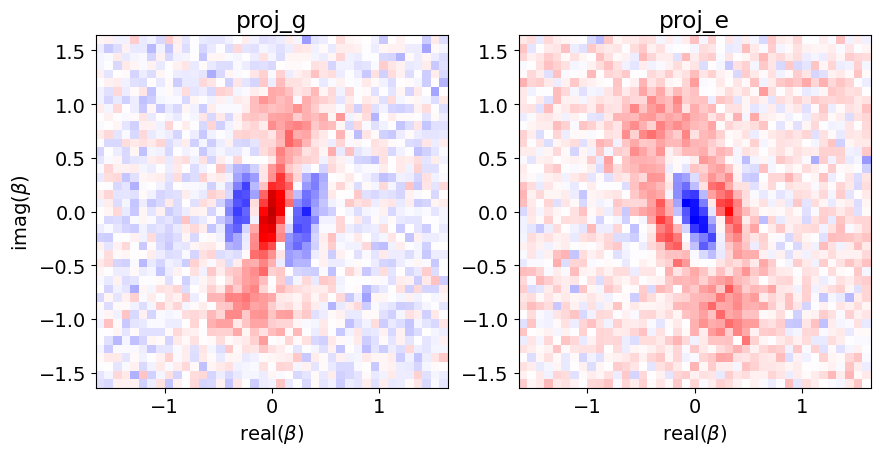

In [205]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma

import os
d = "C:/Users/jonat/Desktop/Coding/tcsim/Data Analysis/Data/"
files = [f for f in os.listdir(d) if f.endswith('panther_Cat_postselection.h5')]
files[-2:-1]


dg = []
de = []

files = files[-5:-1]

for kk in range(len(files)):
    fname = d + files[kk]
    df = h5py.File(fname, "r")
    data = df["data"]
    data_i = data["I"][:]
    x = data["x"][:, 0][:, 0]
    n_points = len(x)  # sweep points
    thresh = +0.00022 #-3.112326057411744e-05
    ss_data = np.where(data_i < thresh, 1, 0)
    m0 = ss_data[:, 0::3]
    m1 = ss_data[:, 1::3] 
    m2 = ss_data[:, 2::3]
    m1_g = ma.masked_array(m1, mask=m0)
    m2_g = ma.masked_array(m2, mask=m0)

    ## only care about last two measurements
    proj_g = ma.masked_array(m2, mask=m1).mean(axis=0).reshape(n_points, n_points) * 2 - 1
    proj_e = ma.masked_array(m2, mask=np.logical_not(m1)).mean(axis=0).reshape(n_points, n_points) * 2 - 1

    ## condition on the first measurement as well
    double_ps_g = ma.masked_array(m2_g, mask=m1_g).mean(axis=0).reshape(n_points, n_points) * 2 - 1
    double_ps_e = ma.masked_array(m2_g, mask=np.logical_not(m1_g)).mean(axis=0).reshape(n_points, n_points) * 2 - 1

    dg.append(double_ps_g)
    de.append(double_ps_e)

    
dg = np.array(dg)
de = np.array(de)


proj_g = dg.mean(axis=0)
proj_e = de.mean(axis=0)
proj_ge = [proj_g, proj_e]  # m2.mean(axis = 0).reshape(n_points, n_points)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 20))
f1 = ax1.pcolormesh(x, x, proj_g, cmap="seismic", vmax=1, vmin=-1)
f2 = ax2.pcolormesh(x, x, proj_e, cmap="seismic", vmax=1, vmin=-1)
ax1.set_aspect("equal")
ax1.set_xlabel(r"real($\beta$)")
ax1.set_ylabel(r"imag($\beta$)")
ax1.set_title('proj_g')
ax2.set_aspect("equal")
ax2.set_xlabel(r"real($\beta$)")
ax2.set_title('proj_e')
# fig.colorbar(f2)


In [234]:
np.mean(proj_g[0])

-0.02065303679109563

C:\Users\jonat\AppData\Local\Temp\ipykernel_30780\3958565016.py:59: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dm = np.zeros((n_disp, d*d), dtype=np.complex)
C:\Users\jonat\AppData\Local\Temp\ipykernel_30780\3958565016.py:43: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ret = np.diag(rvec[:d]).astype(np.complex) # 将r

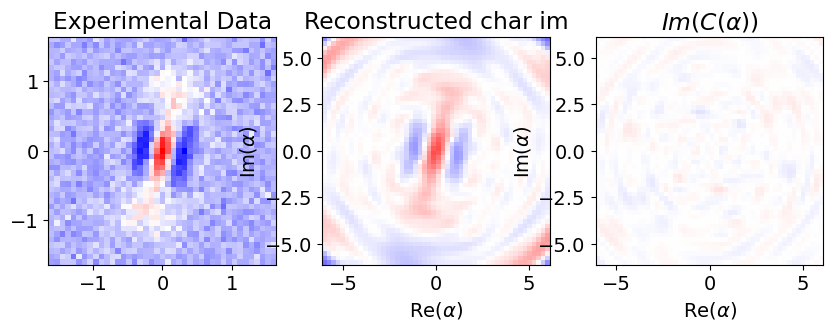

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

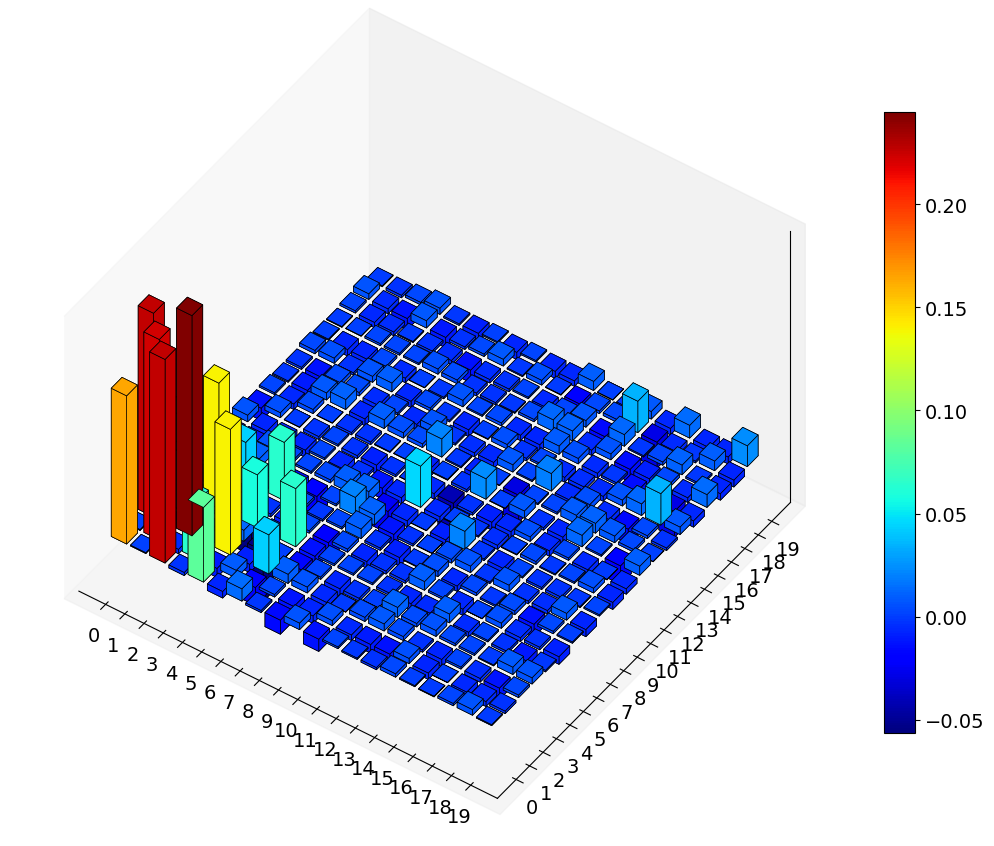

In [235]:

rho = reconstruct_char_from_data(proj_g, x, x, 20, scale=4)
fig, ax = qt.matrix_histogram(rho)
ax.view_init(azim=-55, elev=45)
plt.show()

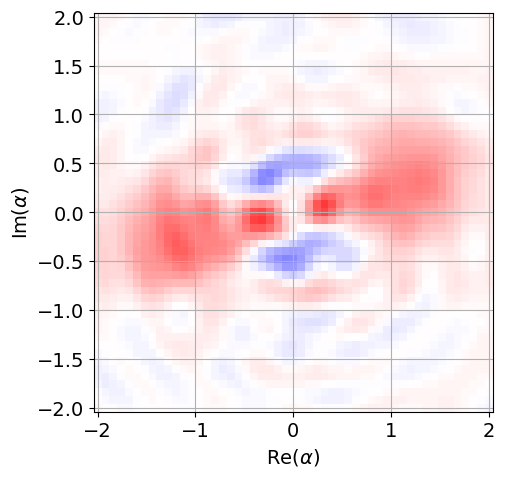

In [239]:
from qutip import*
from tcsim.visualization import plot_wigner
plot_wigner(tensor(fock(2,0)*fock(2,0).dag(),rho))

In [237]:
rho

Quantum object: dims = [[20], [20]], shape = (20, 20), type = oper, isherm = True
Qobj data =
[[ 1.64578949e-01+0.00000000e+00j  8.66371724e-04-7.50636347e-04j
   2.26124072e-01-1.07259118e-01j -3.34483973e-03+1.01419733e-02j
   8.28759664e-02-1.12933867e-01j -7.14826546e-03+3.55766594e-03j
   1.36493427e-02-4.68894827e-02j -2.16619023e-03+3.71452691e-03j
  -1.56693938e-02-1.20032657e-02j  7.12569519e-03+9.35335006e-04j
  -1.36032027e-02-6.86169442e-03j  1.83648633e-03-7.94708757e-03j
  -1.38495035e-03+1.18470418e-02j -2.26426510e-03-1.46842015e-03j
   3.65440126e-03+3.87116672e-03j  1.09983301e-03+6.40506485e-03j
  -7.02211999e-04-3.56083659e-03j  2.40808794e-03+4.40553736e-03j
   6.16998651e-03-4.38077231e-03j -9.62987638e-04-1.79786590e-03j]
 [ 8.66371724e-04+7.50636347e-04j  2.22630376e-01+0.00000000e+00j
  -4.75586526e-03-9.91965784e-03j  6.43659347e-02-2.34278942e-02j
  -9.83155455e-03-1.16330373e-03j  8.48875106e-03-7.28250848e-03j
  -1.99968560e-02+8.86908745e-03j  2.67893633e-

C:\Users\jonat\AppData\Local\Temp\ipykernel_30780\3958565016.py:59: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dm = np.zeros((n_disp, d*d), dtype=np.complex)
C:\Users\jonat\AppData\Local\Temp\ipykernel_30780\3958565016.py:43: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ret = np.diag(rvec[:d]).astype(np.complex) # 将r

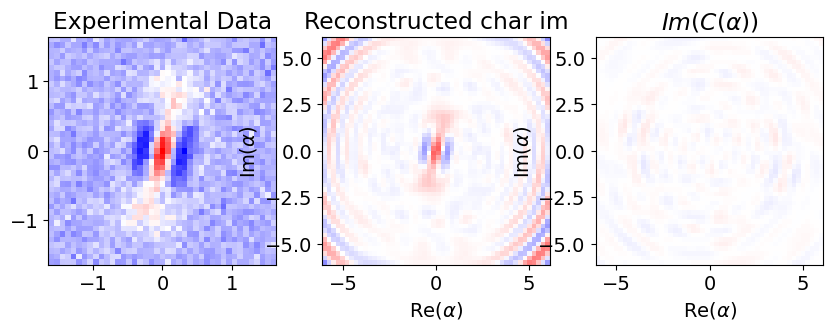

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

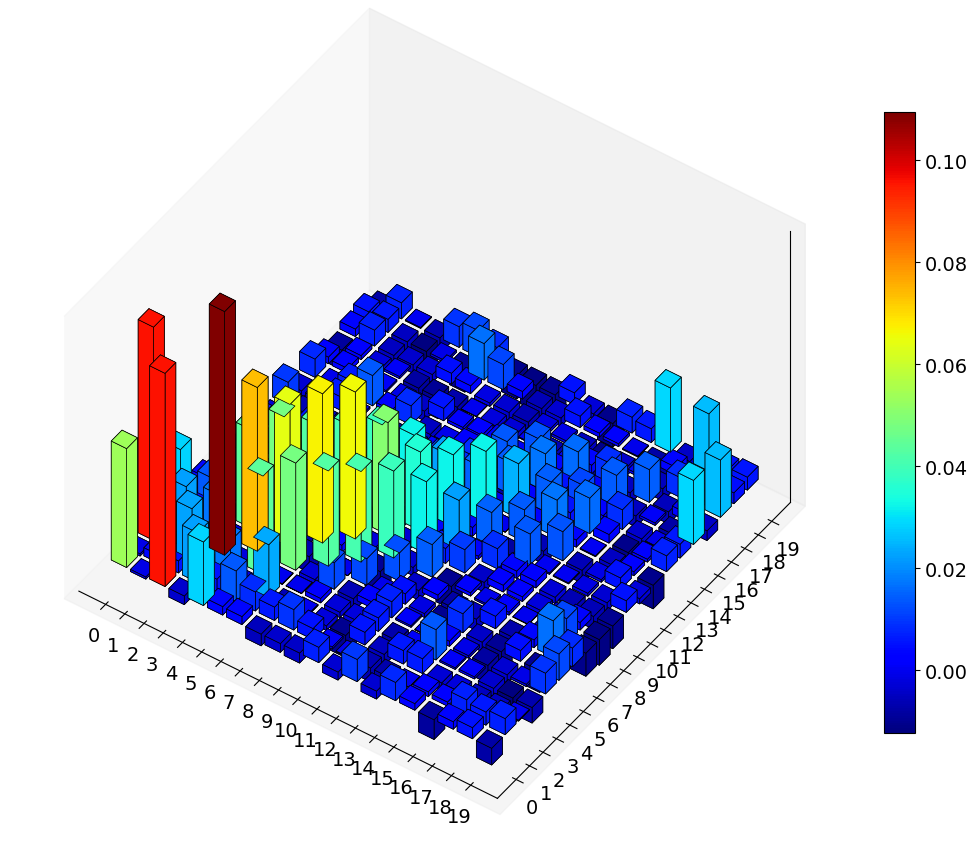

In [232]:

rho = reconstruct_char_from_data(proj_g, x, x, 20, scale=2)
fig, ax = qt.matrix_histogram(rho)
ax.view_init(azim=-55, elev=45)
plt.show()
plot_

C:\Users\jonat\AppData\Local\Temp\ipykernel_30780\2104775779.py:59: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dm = np.zeros((n_disp, d*d), dtype=np.complex)
C:\Users\jonat\AppData\Local\Temp\ipykernel_30780\2104775779.py:43: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ret = np.diag(rvec[:d]).astype(np.complex) # 将r

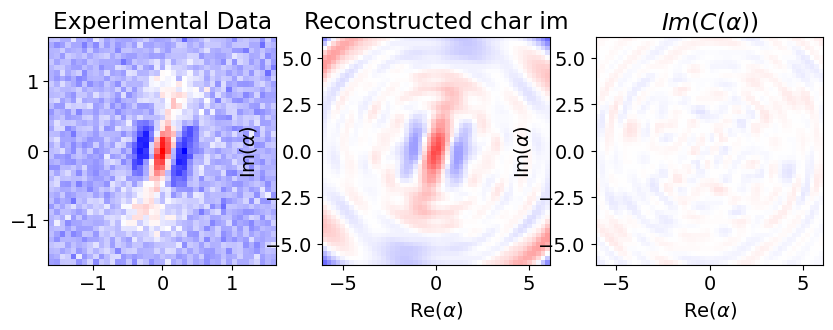

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

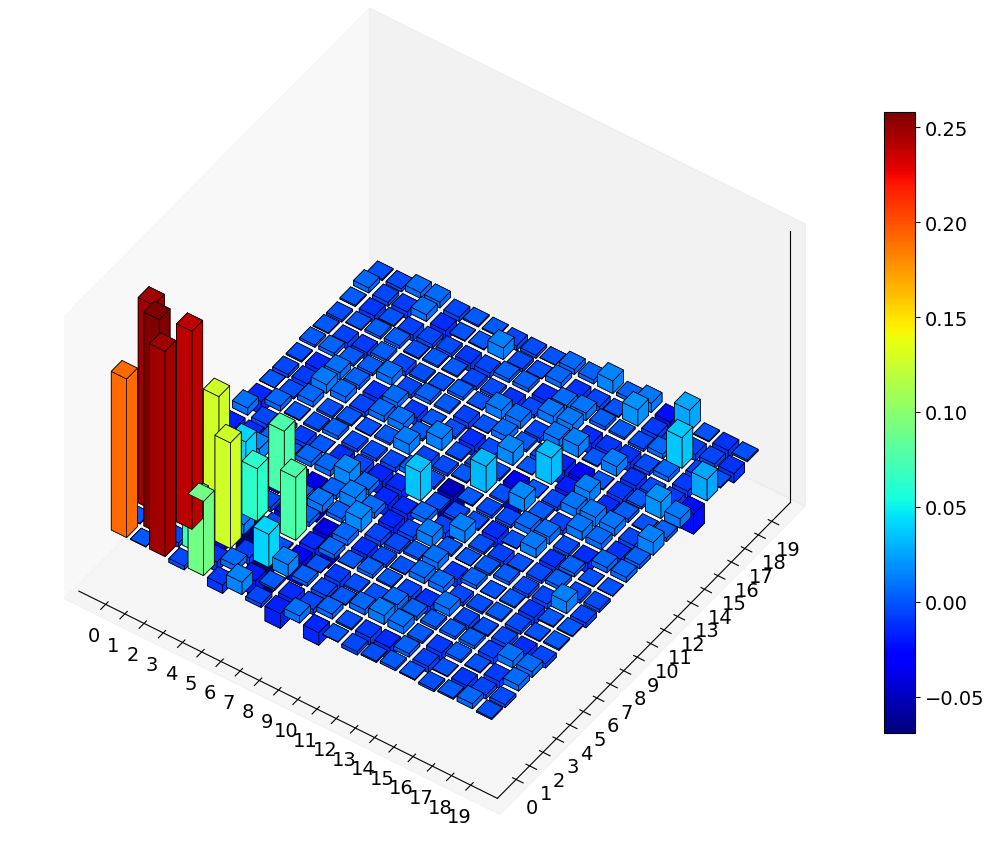

In [228]:

rho = reconstruct_char_from_data(proj_g, x, x, 20, scale=4)
fig, ax = qt.matrix_histogram(rho)
ax.view_init(azim=-55, elev=45)
plt.show()

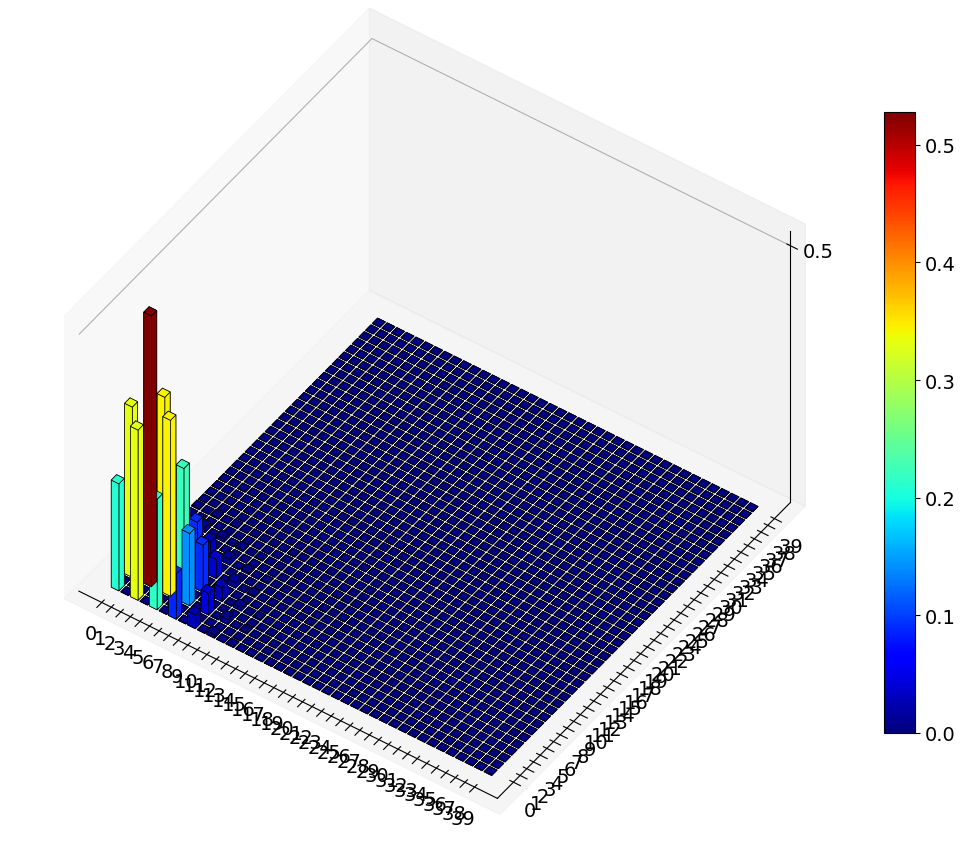

In [224]:
cat = (tensor(fock(2,0),coherent(20,1.5))+tensor(fock(2,0),coherent(20,-1.5))).unit()

fig, ax = qt.matrix_histogram(qt.ket2dm(cat))
ax.view_init(azim=-55, elev=45)
plt.show()